#  Masking Pipeline

In [2]:
from chxanalys.chx_libs import np, roi, time, datetime, os,  getpass, db, get_images,LogNorm, plt,ManualMask

from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames,load_data, 
                                             RemoveHot, show_img, get_avg_img, reverse_updown)
 
%matplotlib notebook

# Path for Saving Results

In [3]:
path = '/XF11ID/analysis/2016_3/masks/'
print ("The analysis results will be saved in : %s"%path)



The analysis results will be saved in : /XF11ID/analysis/2016_2/masks/


### Get the image series and metadata from the uid

In [33]:
uid = '050e24'
uid = '1f0706'

uid = 'af8f66'

uid = 'bb6c9c'  #count : 1 ['bb6c9c'] (scan num: 83) (Measurement: coralpor .002x5000 )
uid = '152a52' # count : 1 ['152a52'] (scan num: 88) (Measurement: direct beam )
uid = 'a80590' #count : 1 ['a80590'] (scan num: 89) (Measurement: air scattering for mask )



In [34]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger4m_single_image
scan_id, full-uid, data path are:  89--a8059087-7d52-4f24-9450-f4a40c799909--/XF11ID/data/2016/08/14/844649a8-ee8b-4f74-8421_6195


In [35]:
#imgs = load_data( uid, detector, reverse= True  )
imgs = load_data( uid, detector, reverse= False  )
md = imgs.md

hdf5 path = /XF11ID/data/2016/08/14/844649a8-ee8b-4f74-8421_6195_master.h5


In [36]:
imgs

<Frames>
Length: 1 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint32

In [37]:
Nimg=len(imgs)

In [38]:
 md['pixel_mask'] =  1- np.int_( np.array( md['pixel_mask'], dtype= bool)  )

## show image and the pixel mask

<IPython.core.display.Javascript object>


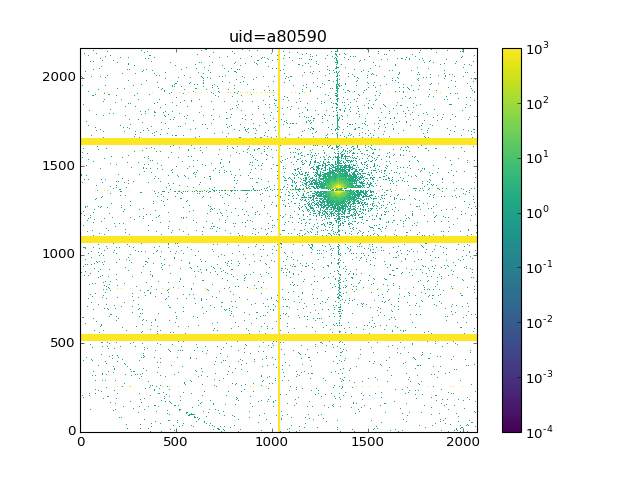

In [25]:
show_img(  imgs[0] , vmin=.0001, vmax=1000, logs=True, image_name ='uid=%s'%uid )





<IPython.core.display.Javascript object>


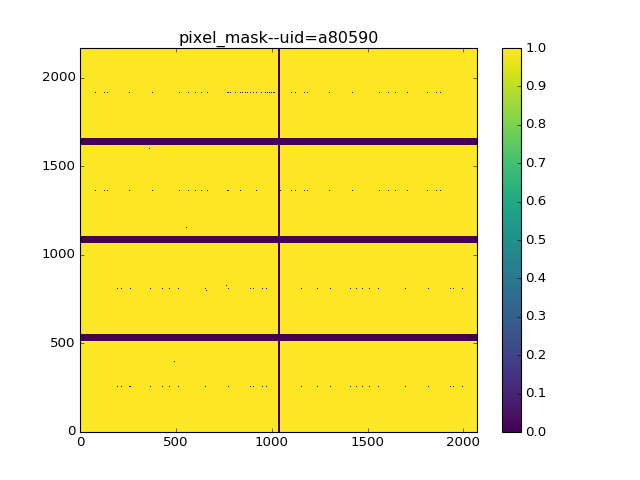

In [39]:
show_img(md['pixel_mask'], vmin=0, vmax=1, image_name ='pixel_mask--uid=%s'%uid )

## Remove hotspots in the image

In [28]:
imgs.shape

(2167, 2070)

In [29]:
2167 - 799

1368

<IPython.core.display.Javascript object>


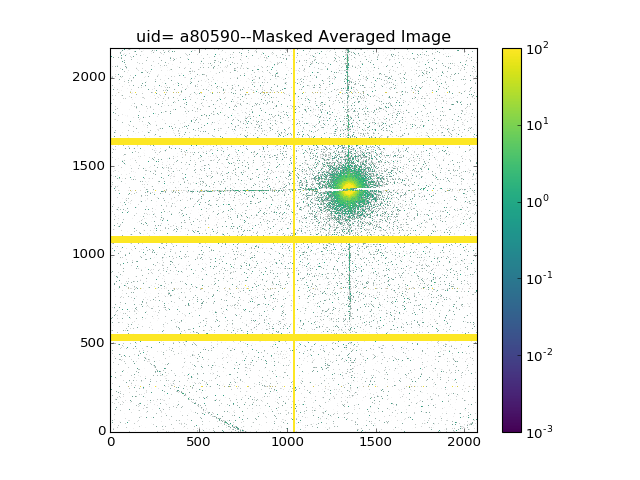

In [30]:
avg_img =  get_avg_img( imgs, sampling = 1000, plot_ = True, uid =uid)

<IPython.core.display.Javascript object>


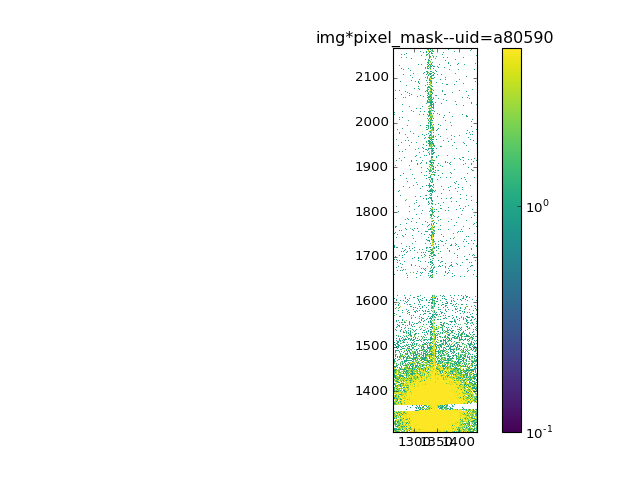

In [42]:
show_img(  avg_img*md['pixel_mask'],   vmin= .1, vmax= 5,
         logs= True, aspect=1.,image_name ='img*pixel_mask--uid=%s'%uid )

In [15]:
avg_img.shape

(2167, 2070)

<IPython.core.display.Javascript object>


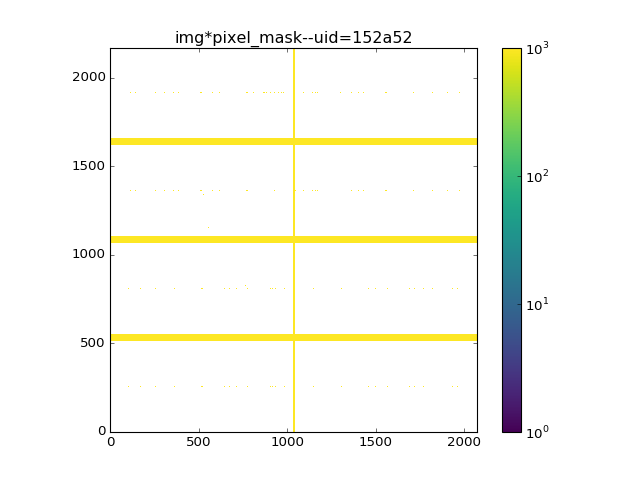

In [16]:
show_img(  avg_img*md['pixel_mask'],   vmin= 1, vmax= 1000,  aspect=1.,
         
         logs= True, image_name ='img*pixel_mask--uid=%s'%uid )

<IPython.core.display.Javascript object>


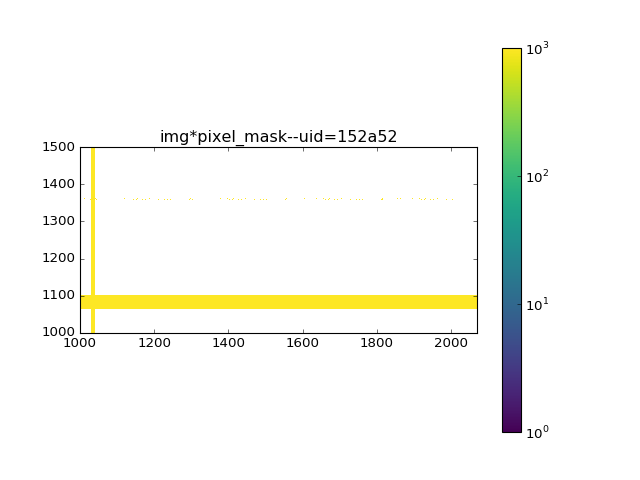

In [17]:
show_img(  avg_img*md['pixel_mask'],   vmin= 1, vmax= 1000, xlim=[1000, 2070], ylim=[1000, 1500], aspect=1.,
         
         logs= True, image_name ='img*pixel_mask--uid=%s'%uid )

In [44]:
avg_img.shape

(2167, 2070)

<IPython.core.display.Javascript object>


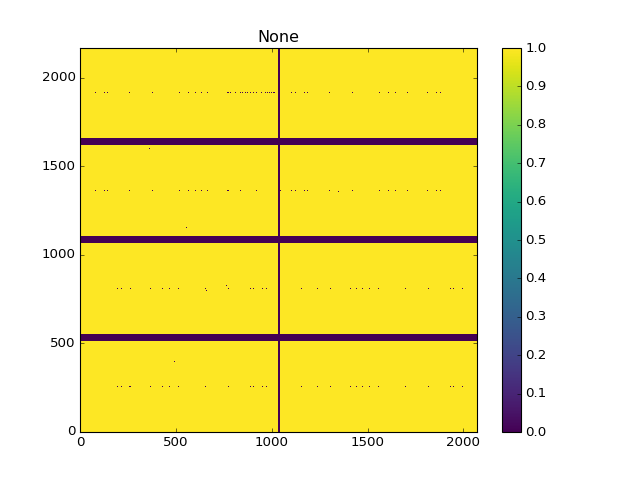

In [45]:
mask_rh  = RemoveHot( avg_img, 5E4, plot_=True)

## Manually create the mask file

<IPython.core.display.Javascript object>


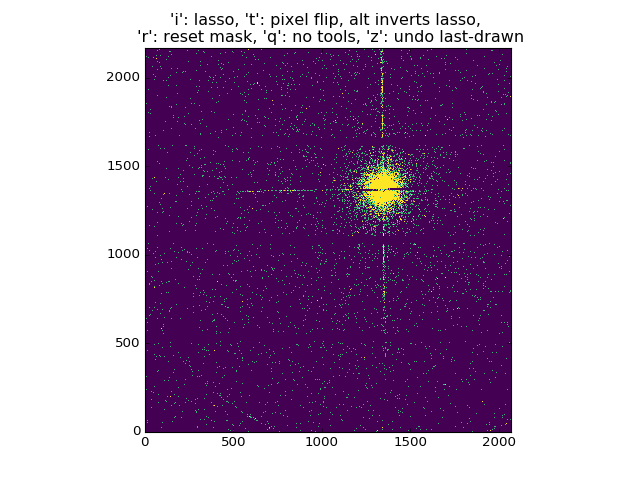

In [46]:
fig, ax = plt.subplots()
m = ManualMask(ax, avg_img* md['pixel_mask']*mask_rh,
               cmap='viridis',origin='lower',
               vmin=.01, vmax=1.50) 
plt.show()

<IPython.core.display.Javascript object>


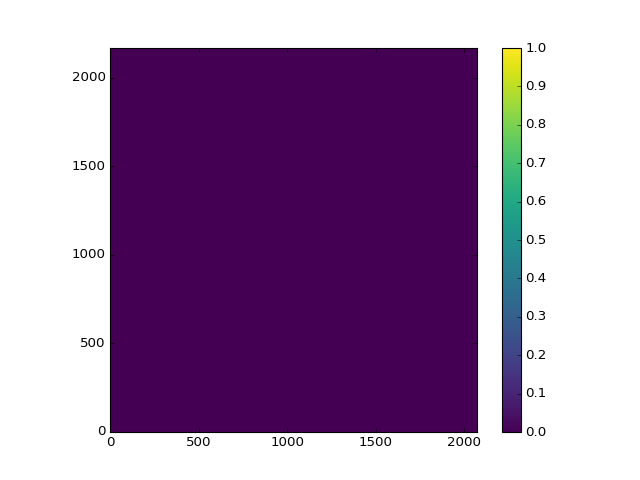

In [49]:
new_mask = m.mask
manu_mask  = new_mask.copy()
fig, ax = plt.subplots()
im=ax.imshow(new_mask,origin='lower' ,vmin=0, vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

In [50]:
manu_mask  = new_mask.copy()

# Create a polygon mask

In [51]:
from skimage.draw import line_aa, line, polygon

### To create multi-rectangle masks, for each sub-mask,
* Make x= the coordinate-x of the four cornners (pay attention to the reserve image-xy to python-xy )
* Make y= the coordinate-y of the four cornners 

In [101]:
#old_center = [1227, 1258]
#new_center = [ 1327, 1358]

#center of beam stop
bst_mask = np.zeros_like( avg_img , dtype = bool)
x = np.array( [ 1200  + 100, 2070, 2070, 1200   + 100])  
y = np.array( [ 1245, 1245, 1285, 1285])  + 100
rr, cc = polygon( y,x)
bst_mask[rr,cc] =1

#the V-beam stop
slit_mask_V = np.zeros_like( avg_img , dtype = bool)
w= 10
x = np.array( [ 1227 - w, 1227 +w, 1227+w, 1227-w])  + 100
y =  np.array( [ 1258, 1258, 0,0 ])  + 100
rr, cc = polygon( y,x)
slit_mask_V[rr,cc] =1

#the V-beam stop
slit_mask_V2 = np.zeros_like( avg_img , dtype = bool)
w= 15
x = np.array( [ 1227 - w, 1227 +w, 1227+ 25, 1227-25])  + 100
y =  np.array( [ 1258  + 100, 1258  + 100, 2167, 2167 ])  

rr, cc = polygon( y,x)
slit_mask_V2[rr,cc] =1


#the H-beam stop
slit_mask_H = np.zeros_like( avg_img , dtype = bool)
w=10
x =  np.array( [ 0  + 100,0  + 100, 2070, 2070])   
y =  np.array( [ 1258-w, 1258+w, 1258+w, 1258-w ])  + 100

rr, cc = polygon( y,x)
slit_mask_H[rr,cc] =1


#the beam stop center 
bst_c = np.zeros_like( avg_img , dtype = bool)

x =  np.array( [1200, 1200, 1227, 1253, 1253, 1227])  + 100
y =  np.array( [ 1272, 1246, 1225, 1246, 1272, 1286])  + 100

rr, cc = polygon( y,x)
bst_c[rr,cc] =1


full_mask=~bst_mask  * ~slit_mask_V * ~slit_mask_V2  * ~slit_mask_H * ~bst_c


In [45]:
#center of beam stop
bst_mask = np.zeros_like( avg_img , dtype = bool)
x = np.array( [ 1300, 1354, 1354, 1300])  
y = np.array( [ 1300, 1300, 2103, 2103])
rr, cc = polygon( y,x)
bst_mask[rr,cc] =1


bst_mask2 = np.zeros_like( avg_img , dtype = bool)
x = np.array( [ 1155, 1155, 2070, 2070])  
y = np.array( [ 1900, 2029, 2121, 1900])
rr, cc = polygon( y,x)
bst_mask2[rr,cc] =1

full_mask=~bst_mask   * ~bst_mask2

In [86]:
#center of beam stop
bst_mask = np.zeros_like( avg_img , dtype = bool)
x = np.array( [ 0,    1342,   2070,   2070,     1342,        0])  
y = np.array( [ 1340, 1345,  1350,    1380,   1375,  1370])
rr, cc = polygon( y,x)
bst_mask[rr,cc] =1


bst_mask2 = np.zeros_like( avg_img , dtype = bool)
x = np.array( [ 1326, 1360, 1360,  1326])  
y = np.array( [ 0, 0, 2167, 2167 ])
rr, cc = polygon( y,x)
bst_mask2[rr,cc] =1

full_mask=~bst_mask    * ~bst_mask2  

<IPython.core.display.Javascript object>


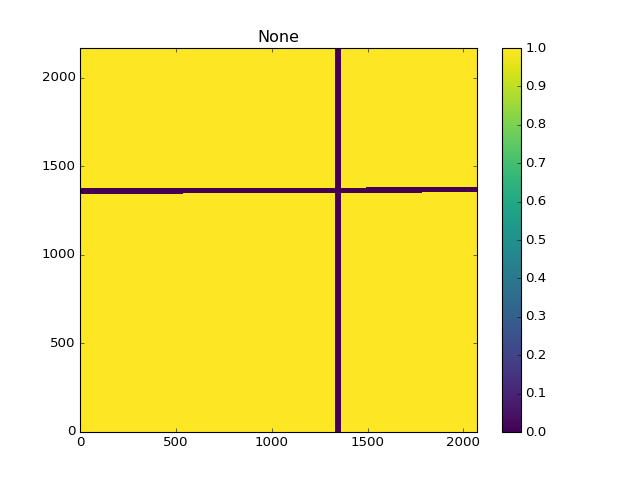

In [87]:
show_img(full_mask)

In [88]:
mask = np.array ( full_mask * md['pixel_mask']*mask_rh *~manu_mask , dtype = bool )

<IPython.core.display.Javascript object>


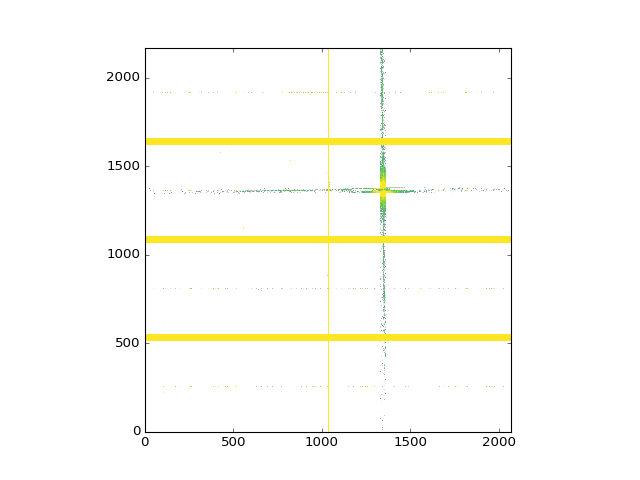

In [89]:
fig, ax = plt.subplots()
#new_mask = 
im=ax.imshow(   (~mask) * avg_img,origin='lower' , 
      norm= LogNorm( vmin=0.001, vmax=30 ), cmap='viridis')
#im = ax.imshow(avg_img,  cmap='viridis',origin='lower', norm= LogNorm( vmin=0.001, vmax=100 ) )
plt.show()


<IPython.core.display.Javascript object>


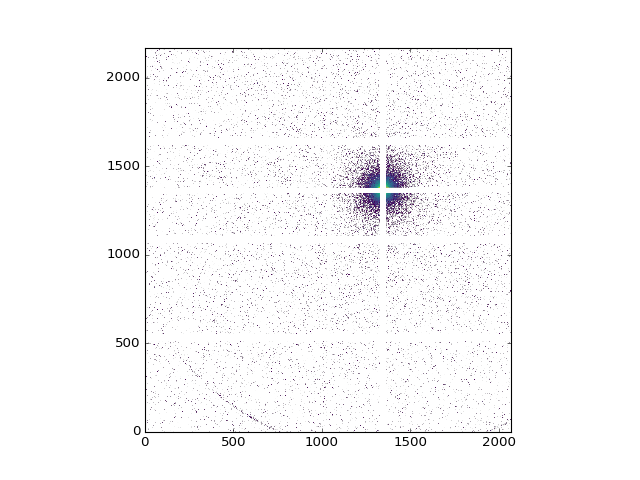

In [90]:
fig, ax = plt.subplots()
#new_mask = 
#im=ax.imshow(   (Mask) * avg_img,origin='lower' , 
#      norm= LogNorm( vmin=0.001, vmax=30 ), cmap='viridis')
#im = ax.imshow((mask)*avg_img,  cmap='viridis',origin='lower', norm= LogNorm( vmin=0.001, vmax=100 ) )
im = ax.imshow((mask)*avg_img,  cmap='viridis',origin='lower', norm= LogNorm( vmin=1, vmax=1000 ) )
plt.show()

## Combine the hand-drawn/polygon mask and the pixel mask and hot pixel mask

<IPython.core.display.Javascript object>


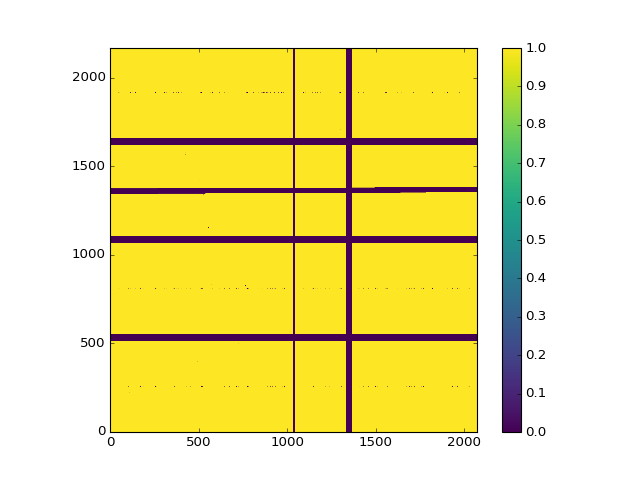

In [91]:
#mask = np.array ( ~new_mask* ~plgon_mask * md['pixel_mask']*mask_rh, dtype = bool )

fig, ax = plt.subplots()
im=ax.imshow(mask, origin='lower' ,vmin=0, vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## Save the combined mask to use in further data analysis

In [92]:
np.save(  path +   uid +"_mask", mask)

In [108]:
#np.save(  path +   'July3' +"_mask", mask)

In [93]:
path +   uid +"_mask"

'/XF11ID/analysis/2016_2/masks/a80590_mask'

In [94]:
np.save(  path +   'Aug14' +"_mask", mask)